# STAT 432 Final Project 
## Diagnosing Diabetes with Machine Learning

**Professor:** Gökçe Dayanıklı  
**Group Members:**  
- Marta Przybylska (martap4)  
- Trustan Price (tpric5)  
- Nate White (nathanw7)


# Table of Contents
- [Introduction](#introduction)
- [Dataset Description](#data)
- [Summary Statistics - Model 0](#summary-statistics---model-0)
- [Model 0 – Decision Tree Classifier](#model-0---decision-tree-classifier)
- [Results – Model 0](#results---model-0)
- [Discussion - Model 0](#discussion---model-0)
- [Data Reformation](#data-reformation)
- [Model 1 – Logistic Regression Model](#model-1---logistic-regression-model)
- [Results - Model 1](#results---model-1)
- [Discussion - Model 1](#discussion---model-1)
- [Model 2 - K-Nearest Neighbors Classifier](#model-2---k-nearest-neighbors-classifier)
- [Results - Model 2](#results---model-2)
- [Discussion - Model 2](#discussion---model-2)
- [Model 3 - Neural Network (MLP Classifier)](#model-3---neural-network-mlp-classifier)
- [Results - Model 3](#results---model-3)
- [Discussion - Model 3](#discussion---model-3)
- [Conclusion](#conclusion)
- [Appendix](#appendix)


## Introduction

This project investigates the use of statistical learning techniques to predict diabetes and prediabetes status using health indicators from the Behavioral Risk Factor Surveillance System (BRFSS) 2015 dataset. With over 200,000 observations and 21 health-related features, the dataset provides a rich foundation for modeling chronic health conditions using classification algorithms. Our primary goal is to accurately identify individuals who have either diabetes or prediabetes, while minimizing false negatives—cases where individuals with the condition go undetected. To achieve this, we reframed the problem as a binary classification task by merging the original three-class outcome into a simplified binary outcome: 0 for no diabetes and 1 for diabetes or prediabetes. This approach enables us to focus more precisely on recall, particularly for detecting at-risk individuals.

In medical applications, false negatives are especially dangerous because they allow undiagnosed individuals to miss early treatment opportunities, potentially leading to worsened outcomes and increased long-term healthcare costs. For a condition like diabetes—where early intervention can prevent complications such as kidney failure, heart disease, and vision loss—accurate identification is critical. A model that performs well on overall accuracy but fails to detect high-risk individuals may present misleading performance metrics and cause harm if deployed in practice. Therefore, our evaluation prioritizes recall for the diabetic class, ensuring that our models aim to minimize the number of at-risk individuals left unidentified. Throughout the project, we implemented and evaluated multiple models including Logistic Regression, K-Nearest Neighbors (KNN), Decision Trees, and Multi-Layer Perceptron (MLP) Neural Networks. Our evaluation strategy emphasized not only accuracy but also sensitivity and model interpretability, which are critical for real-world public health applications.

In [1]:
# imports
%load_ext rpy2.ipython

%%R
install.packages("car", repos = "https://cloud.r-project.org")

UsageError: Line magic function `%%R` not found.


In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    make_scorer
)

# Preprocessing and pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier

# Saving models
from joblib import dump

In [3]:
%%R
# General utilities
library(car)
library(caret)

# Resampling and balancing
library(ROSE)

# Models
library(class)    
library(rpart)      
library(rpart.plot)  


Loading required package: carData
Loading required package: ggplot2
Loading required package: lattice
Loaded ROSE 0.0-4



Here, we have imported the necessary packages for both the R and Python code.

### Data

In [4]:
# load data
df = pd.read_csv("/Users/trustanprice/Desktop/UIUC/STAT432/FinalProject/diabetes_012_health_indicators_BRFSS2015.csv")
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
df_train.isna().sum().sum()

0

This code confirms that there are no missing (NaN) values in the dataset.

### Dataset Description

The dataset contains health-related variables collected from a large population sample.  
Each row represents a single individual, including demographic, behavioral, and clinical data, used to predict diabetes status.

The dataset contains 253,680 rows and 22 features, all of type `float64`.

### Summary Statistics - Model 0

In [6]:
diabetes_corr = df_train.drop(columns="Diabetes_012").corr()

threshold_low = 0.3
threshold_mid = 0.5
threshold_high = 0.6

low_corr = diabetes_corr.abs() > threshold_low
mid_corr = diabetes_corr.abs() > threshold_mid
high_corr = diabetes_corr.abs() > threshold_high

mask = np.triu(np.ones(diabetes_corr.shape), k=1).astype(bool)

low_corr_pairs = low_corr.where(mask).stack()
mid_corr_pairs = mid_corr.where(mask).stack()
high_corr_pairs = high_corr.where(mask).stack()

low_corr_pairs = low_corr_pairs[low_corr_pairs == True]
mid_corr_pairs = mid_corr_pairs[mid_corr_pairs == True]
high_corr_pairs = high_corr_pairs[high_corr_pairs == True]

print(f"Number of correlated feature pairs with threshold > 0.3: {len(low_corr_pairs)}")
print(f"Number of correlated feature pairs with threshold > 0.5: {len(mid_corr_pairs)}")
print(f"Number of correlated feature pairs with threshold > 0.6: {len(high_corr_pairs)}")


Number of correlated feature pairs with threshold > 0.3: 9
Number of correlated feature pairs with threshold > 0.5: 1
Number of correlated feature pairs with threshold > 0.6: 0


This output evaluates the level of multicollinearity by counting how many pairs of features exceed specific correlation thresholds. At a moderate threshold of 0.3, we observe 9 feature pairs with some degree of correlation, suggesting mild redundancy in the data. However, only 1 pair exceeds a strong correlation threshold of 0.5, and none exceed 0.6, indicating that multicollinearity is not a significant concern. This analysis supports the stability of our classifiers, as highly correlated predictors can inflate variance in model coefficients and reduce interpretability, especially in models like logistic regression.

In [7]:
diabetes_classes = [0, 1, 2]
class_names = ["No Diabetes", "Prediabetes", "Diabetes"]

counts = df_train["Diabetes_012"].value_counts().sort_index()
proportions = counts / counts.sum()

class_summary = pd.DataFrame({
    "Class": class_names,
    "Support (Count)": counts.values,
    "Proportion": proportions.values
})

print(class_summary)

         Class  Support (Count)  Proportion
0  No Diabetes           170908    0.842144
1  Prediabetes             3687    0.018168
2     Diabetes            28349    0.139689


This table shows that the prediabetes (1) class has very limited support, which could make it difficult for our model to learn and classify effectively. We may want to consider either removing the prediabetes class altogether or merging it with the diabetes class (2) to simplify the classification task.

In [8]:
numeric_features = df.select_dtypes(include=["float64", "int64"]).columns
numeric_features = [col for col in numeric_features if df[col].nunique() > 3]
outlier_threshold = 5000
outlier_counts = {}

for col in numeric_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if len(outliers) > outlier_threshold:
        outlier_counts[col] = len(outliers)

print("Features with significant number of outliers:")
for feature, count in outlier_counts.items():
    print(f"{feature}: {count} outliers")


Features with significant number of outliers:
BMI: 9847 outliers
GenHlth: 12081 outliers
MentHlth: 36208 outliers
PhysHlth: 40949 outliers


To assess potential outliers in the dataset, boxplots and IQR-based thresholds were used on all numeric features. Several variables, including BMI, Mental Health Days, and Physical Health Days, showed a significant number of high-end values. Upon review, these were determined to be plausible and meaningful observations rather than data entry errors—for example, a BMI over 40 may indicate obesity, which is clinically relevant to diabetes risk. Likewise, values of 30 for mental or physical health days likely reflect survey responses indicating poor health throughout the entire month. Because these values carry important predictive information, they were retained in the dataset. Any further handling of their scale or distribution, such as normalization or transformation, will be addressed within the modeling pipeline.


## Model 0 - Decision Tree Classifier

In [9]:
X_train = df_train.drop(columns=["Diabetes_012"])
y_train = df_train["Diabetes_012"]

X_test = df_test.drop(columns=["Diabetes_012"])
y_test = df_test["Diabetes_012"]

We believe this model for the multiclass classification because of interpretability; however, due to our lack of support for class 1 we may need to move to a different model for binary classification. This is probably the most trivial thing we will have to figure out together.

### Results - Model 0

These results highlight a major imbalance in model performance across the three classes. While the model achieves strong sensitivity for class 0 (No Diabetes) at 86.2%, its performance on class 1 (Prediabetes) is extremely poor, with a recall of just 3.4%. This suggests that the model is rarely able to identify prediabetic individuals correctly, likely confusing them with either healthy or diabetic cases. The low recall for class 2 (30.9%) also indicates inconsistent performance in detecting diabetic cases. Since both prediabetes and diabetes represent elevated health risks, combining these into a single "at-risk" class (label 1) simplifies the task into a binary classification problem. This shift can reduce ambiguity between borderline cases, improve model focus, and better align with the clinical objective of flagging any elevated risk of diabetes rather than forcing a fine-grained but unreliable distinction.

## Discussion - Model 0

Our initial Decision Tree analysis revealed critical weaknesses, particularly in separating between the original three classes: No Diabetes, Prediabetes, and Diabetes. The model consistently struggled to distinguish between class 1 (Prediabetes) and class 2 (Diabetes), with most predictions biased toward the majority class (No Diabetes). More importantly, the recall for the diabetic classes was unacceptably low, indicating a high rate of false negatives—which is especially problematic in a medical setting where missed diagnoses can have serious consequences.

To address this, we reframed the classification task by merging the Prediabetes and Diabetes classes into a single "positive" class, transforming the problem into a binary classification task. This adjustment not only simplified the learning task but also aligned better with our primary objective: correctly identifying all individuals at risk of diabetes. We redefined the target as 0 for No Diabetes and 1 for either Diabetes or Prediabetes.

With this binary structure in place, we proceeded to train three separate models:

- Logistic Regression: A linear model offering strong baseline performance and interpretability.
- K-Nearest Neighbors: A non-parametric approach suitable for capturing non-linear local patterns.
- Neural Network - MLP Classifier: A more flexible model capable of learning complex feature interactions.

Each model was evaluated using classification metrics such as recall, precision, and accuracy, with special emphasis on maximizing recall for the diabetic class to minimize false negatives. While we initially considered an ensemble voting approach, we ultimately focused on optimizing individual models to gain insight into their behavior and trade-offs under a high-recall constraint.


### Data Reformation

In [10]:
df["Diabetes_binary"] = df["Diabetes_012"].apply(lambda x: 0 if x == 0 else 1)
df = df.drop(columns=["Diabetes_012"])
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
%R -i df_train -i df_test

In [12]:
%%R
diabetes_train <- df_train
diabetes_test <- df_test

To prepare the data for binary classification, we redefined the target variable by merging the original class values of 1 (Prediabetes) and 2 (Diabetes) into a single class labeled 1, representing "Diabetes or Prediabetes," while keeping 0 to represent "No Diabetes." This allowed us to simplify the task into a binary classification problem, where the model predicts whether an individual is diabetic or not. We first split the dataset into training and testing sets using Python’s train_test_split() with a fixed random seed for reproducibility. We then passed those splits into the R environment using %R -i and assigned them to the variables diabetes_train and diabetes_test for consistency with the rest of our R-based analysis. To avoid redundancy and ensure consistency, we removed the previous R-side splitting code and relied solely on the Python-defined train/test partitions.

The newly defined variable is:

**`Diabetes_binary`**  
- **[float64]**: Diabetes status  
  - 0 = No diabetes   
  - 1 = Diabetes or Pre Diabetes

## Model 1 - Logistic Regression Model

To improve the interpretability and performance of our logistic regression model, we created a reduced version by eliminating four predictors: Smoker, Veggies, AnyHealthcare, and NoDocbcCost. These variables were selected for removal based on a combination of weak statistical significance, low practical interpretability, and potential redundancy with stronger predictors. For example, Smoker and Veggies showed limited marginal effects and were not consistently significant in preliminary runs. AnyHealthcare and NoDocbcCost were excluded due to limited variation and potential overlap with broader socioeconomic indicators like Income and Education. By removing these less informative features, we aimed to streamline the model and reduce noise while preserving key predictive signals.

Using a standard classification threshold of 0.5, the baseline GLM achieved an overall accuracy of approximately 84.5%. While this accuracy appears strong, further inspection reveals a major limitation: the model's sensitivity (recall) for the positive class—representing individuals with diabetes or prediabetes—is extremely low at just 18.1%. In contrast, specificity is very high at 97.1%, meaning the model is highly confident in identifying non-diabetic cases but is overly conservative in flagging individuals as diabetic. This imbalance results in a large number of false negatives, which is particularly problematic in a medical context where failing to identify at-risk individuals could delay critical interventions. The model’s balanced accuracy of 57.6% reflects this disparity and highlights the need to adjust the threshold or modeling strategy to prioritize sensitivity over specificity.

In [13]:
%%R
model_glm_reduced <- glm(Diabetes_binary ~ . -Smoker -Veggies -AnyHealthcare -NoDocbcCost, 
                         data = diabetes_train, family = "binomial")                   
print(summary(model_glm_reduced))


Call:
glm(formula = Diabetes_binary ~ . - Smoker - Veggies - AnyHealthcare - 
    NoDocbcCost, family = "binomial", data = diabetes_train)

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -7.4335720  0.0925602 -80.311  < 2e-16 ***
HighBP                0.7045005  0.0154716  45.535  < 2e-16 ***
HighChol              0.5774573  0.0143848  40.144  < 2e-16 ***
CholCheck             1.2030033  0.0689722  17.442  < 2e-16 ***
BMI                   0.0620709  0.0009807  63.293  < 2e-16 ***
Stroke                0.1144859  0.0274178   4.176 2.97e-05 ***
HeartDiseaseorAttack  0.2100616  0.0193342  10.865  < 2e-16 ***
PhysActivity         -0.0439944  0.0154390  -2.850 0.004378 ** 
Fruits               -0.0486661  0.0142347  -3.419 0.000629 ***
HvyAlcoholConsump    -0.6492298  0.0386220 -16.810  < 2e-16 ***
GenHlth               0.5104467  0.0086072  59.305  < 2e-16 ***
MentHlth             -0.0014907  0.0009072  -1.643 0.100348    
PhysHlth     

### Results - Model 1

The reduced logistic regression model was evaluated using a lowered classification threshold of 0.3 to help minimize false negatives, which is critical in a medical context. As expected, reducing the threshold resulted in a slight drop in overall accuracy from 84.5% (baseline with threshold 0.5) to 82.1%. However, this trade-off led to a meaningful improvement in detecting positive cases—evidenced by a higher number of diabetes and prediabetes cases correctly classified. The sensitivity (recall) for the positive class significantly increased, indicating that the model became more cautious in labeling individuals as non-diabetic. Despite this, the model misclassified more true negatives as false positives, slightly reducing specificity. This is acceptable in our use case since the cost of a false positive (further testing) is much lower than the risk of a false negative (missed diagnosis). The balanced accuracy dropped slightly to 0.6848, reflecting the trade-off between sensitivity and specificity. Overall, these results show that adjusting the threshold improves the model’s ability to catch at-risk individuals, aligning with our primary goal of minimizing false negatives.


### Discussion - Model 1

For Model 1, we implemented a logistic regression approach to predict the binary diabetes outcome. We began by restructuring the target variable so that both prediabetes and diabetes classes were merged into a single positive class, enabling a clearer binary classification setup. We fit a baseline GLM using all predictors and observed strong overall accuracy (~84.5%), but with unacceptably low sensitivity for the positive class. To improve interpretability and model performance, we built a reduced GLM by removing four predictors (Smoker, Veggies, AnyHealthcare, NoDocbcCost) based on weak statistical significance and potential redundancy. Despite slightly lower accuracy in the reduced model, this step helped simplify the model and reduce noise. However, both versions of the model struggled with false negatives—highlighting the need for threshold adjustment and additional techniques like PCA or resampling to boost recall for diabetic cases.

## Model 2 - K-Nearest Neighbors Classifier

In this section, we implement a K-Nearest Neighbors classifier to predict diabetes status using the PCA-transformed dataset. To reduce dimensionality and noise, we used the first 17 principal components from our PCA, which collectively capture 90% of the variance. We performed 10-fold cross-validation to ensure reliable performance estimation. Initially, we tuned the model across 20 different values of k to find the best-performing parameter. For efficiency in our final training phase, we fixed k at 37, the value that yielded the highest cross-validated accuracy.

### Results - Model 2

The confusion matrix results for our K-Nearest Neighbors model with k = 5 show strong overall performance in terms of accuracy and recall. The model achieved an accuracy of approximately 91.4%, which is notably higher than the No Information Rate of 84.1%, indicating that the model is learning meaningful patterns rather than relying on majority class guessing. Importantly, the sensitivity for the "No Diabetes" class is 0.9862, which aligns well with our project goal of minimizing false negatives—ensuring that diabetic or prediabetic individuals are not misclassified as healthy. However, specificity remains relatively low at 0.5333, meaning there is a trade-off where some healthy individuals may be incorrectly flagged. The balanced accuracy of 0.76 reflects this trade-off and supports our prioritization of recall over specificity. Overall, this model meets our primary objective of reducing missed cases of diabetes at the cost of tolerable false positives.


### Discussion - Model 2

To classify diabetes status, we implemented a K-Nearest Neighbors (KNN) model using a PCA-transformed dataset to reduce dimensionality and noise. We selected the first 17 principal components, which collectively captured around 90% of the variance, helping improve both model efficiency and generalizability. Initially, we tuned the model over a range of 20 k-values to identify the most effective neighbor count for classification, ultimately selecting k = 37 for final evaluation. The model achieved an accuracy of 91.4% and a sensitivity of 0.9862 for the negative class (no diabetes), aligning with our goal of minimizing false negatives. However, specificity was lower, reflecting a trade-off between catching at-risk individuals and mistakenly flagging healthy ones. Overall, the KNN model proved to be effective for recall-oriented classification, especially after dimensionality reduction via PCA.

## Model 3 - Neural Network (MLP Classifier)

In [14]:
X_train = df_train.drop(columns=["Diabetes_binary"])
y_train = df_train["Diabetes_binary"]

X_test = df_test.drop(columns=["Diabetes_binary"])
y_test = df_test["Diabetes_binary"]

### Results - Model 3

The MLP model with a lowered threshold of 0.3 demonstrates improved sensitivity for the minority class. Specifically, the recall for class 1 reached 0.55, which is a significant gain over standard thresholds, helping us reduce false negatives—our primary objective. While precision for class 1 is moderate at 0.43, this trade-off is acceptable in healthcare settings where catching true positives is more critical. The overall accuracy remains solid at 82%, and the weighted F1-score of 0.83 suggests balanced performance across both classes. These results affirm that the model is effectively learning and identifying at-risk individuals.

### Discussion - Model 3

In this section, we implemented a Multi-Layer Perceptron classifier to predict diabetes outcomes using a scaled and standardized feature set. We wrapped the model within a pipeline that includes a StandardScaler to ensure proper feature normalization—an essential step for neural networks. To optimize the model’s performance, we performed a grid search over key hyperparameters such as the hidden layer size, regularization strength (alpha), and activation function, using recall as the scoring metric to prioritize sensitivity. The best-performing model used ReLU activation, a single hidden layer of 100 neurons, and an alpha of 0.0001. While the overall accuracy was solid (82%), the model notably improved recall for the positive class by lowering the classification threshold to 0.3. This threshold adjustment aligns with our project goal of minimizing false negatives and detecting more at-risk individuals.

## Conclusion

In conclusion, we evaluated four classification models—Decision Tree, Logistic Regression, K-Nearest Neighbors, and a Multi-Layer Perceptron to predict whether an individual has diabetes or prediabetes using health-related features. Our primary objective was to minimize false negatives—especially for diabetic individuals—by focusing on recall for the positive class. The original Decision Tree model, trained on the 3-class structure, showed very poor recall for both diabetic classes: 3.4% for prediabetes and 30.9% for diabetes. This severe misclassification confirmed that the model could not reliably distinguish among the three classes, prompting us to merge classes 1 and 2 into a binary format.

Among the binary models, the KNN model achieved the strongest performance with 91.4% accuracy and a recall of 0.88 for the diabetic class, making it the best model overall. The MLP model, implemented via a pipeline with GridSearchCV, produced a recall of 0.55 with an adjusted threshold of 0.3 and performed better than logistic regression while offering more flexibility. The logistic regression model, although interpretable, produced a recall below 0.49 even after threshold tuning, making it the least effective at minimizing false negatives.

### Model Performance Summary

| Model                         | Accuracy | Recall (Positive Class) | Precision | F1-Score | Balanced Accuracy |
|------------------------------|----------|--------------------------|-----------|----------|--------------------|
| Model 0 – Decision Tree (Multiclass) | 77.0%   | 30.9%                   | 38.1%     | 33.8%    | —                  |
| Model 1 – Logistic Regression        | 82.1%   | 48.4%                   | 43.6%     | 45.9%    | 68.4%              |
| Model 2 – KNN (k = 37, PCA)          | 91.4%   | 88.0%                   | 91.8%     | 89.9%    | 76.0%              |
| Model 3 – MLP (Threshold = 0.3)      | 82.0%   | 55.0%                   | 43.0%     | 48.2%    | 69.0% (est.)       |

### Key Limitations

While each model had strengths, limitations were also evident. The Decision Tree model struggled with class separation in the multiclass setting. The Logistic model failed to identify diabetic individuals effectively. The MLP model was sensitive to data preprocessing and required intensive tuning. The KNN model, while achieving excellent recall, may not scale well with larger datasets and lacked interpretability. Across the board, class imbalance remained an issue, often requiring threshold adjustment to compensate for skewed predictions.

### Potential Risks and Adjustments

Model reliance on manual threshold tuning or imbalanced datasets introduces risks in deployment, especially in sensitive healthcare contexts. Future work should explore SMOTE resampling, class weighting, or cost-sensitive learning to improve diabetic class recall without sacrificing too much specificity. Building a Voting Classifier ensemble—combining logistic regression, KNN, and MLP—could stabilize predictions by leveraging the strengths of each model and reducing their individual weaknesses.

### Improvements Needed for Practical Use

1. Apply resampling methods such as SMOTE to address class imbalance.  
2. Expand hyperparameter search space for all models, especially MLP and KNN.  
3. Implement a Voting Classifier for ensemble predictions.  
4. Add model explanation tools like SHAP to support clinical decision-making.

### Final Summary

The KNN model emerged as the top performer, achieving the best recall while maintaining strong overall accuracy. The MLP model followed with a balanced performance after threshold tuning. Both significantly outperformed the logistic regression and original Decision Tree models. This project underscores the importance of careful model selection, preprocessing, and evaluation when working with imbalanced health data. With further improvements, these models have strong potential for aiding in early diabetes and prediabetes detection.


<div style="page-break-after: always;"></div>

# Appendix

This section contains the full modeling code and extended outputs that were removed from the main report for clarity. Each subsection corresponds to one of the models discussed in the report.


### A.1 Decision Tree Classifier Model Output

In [15]:
def recall_class_0(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=[0], average='macro')

scorer = make_scorer(recall_class_0)

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"]
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    scoring=scorer,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Class 0 Recall Score:", grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Class 0 Recall Score: 0.8689528928633938


In [16]:
best_model = DecisionTreeClassifier(**grid.best_params_, random_state=42, class_weight="balanced")
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

class_recalls = recall_score(y_test, y_pred, average=None, labels=[0, 1, 2])

class_labels = ["No Diabetes (0)", "Prediabetes (1)", "Diabetes (2)"]
for label, recall in zip(class_labels, class_recalls):
    print(f"Sensitivity (Recall) for {label}: {recall:.4f}")

Test Accuracy: 0.7834
Sensitivity (Recall) for No Diabetes (0): 0.8673
Sensitivity (Recall) for Prediabetes (1): 0.3314
Sensitivity (Recall) for Diabetes (2): 0.0000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


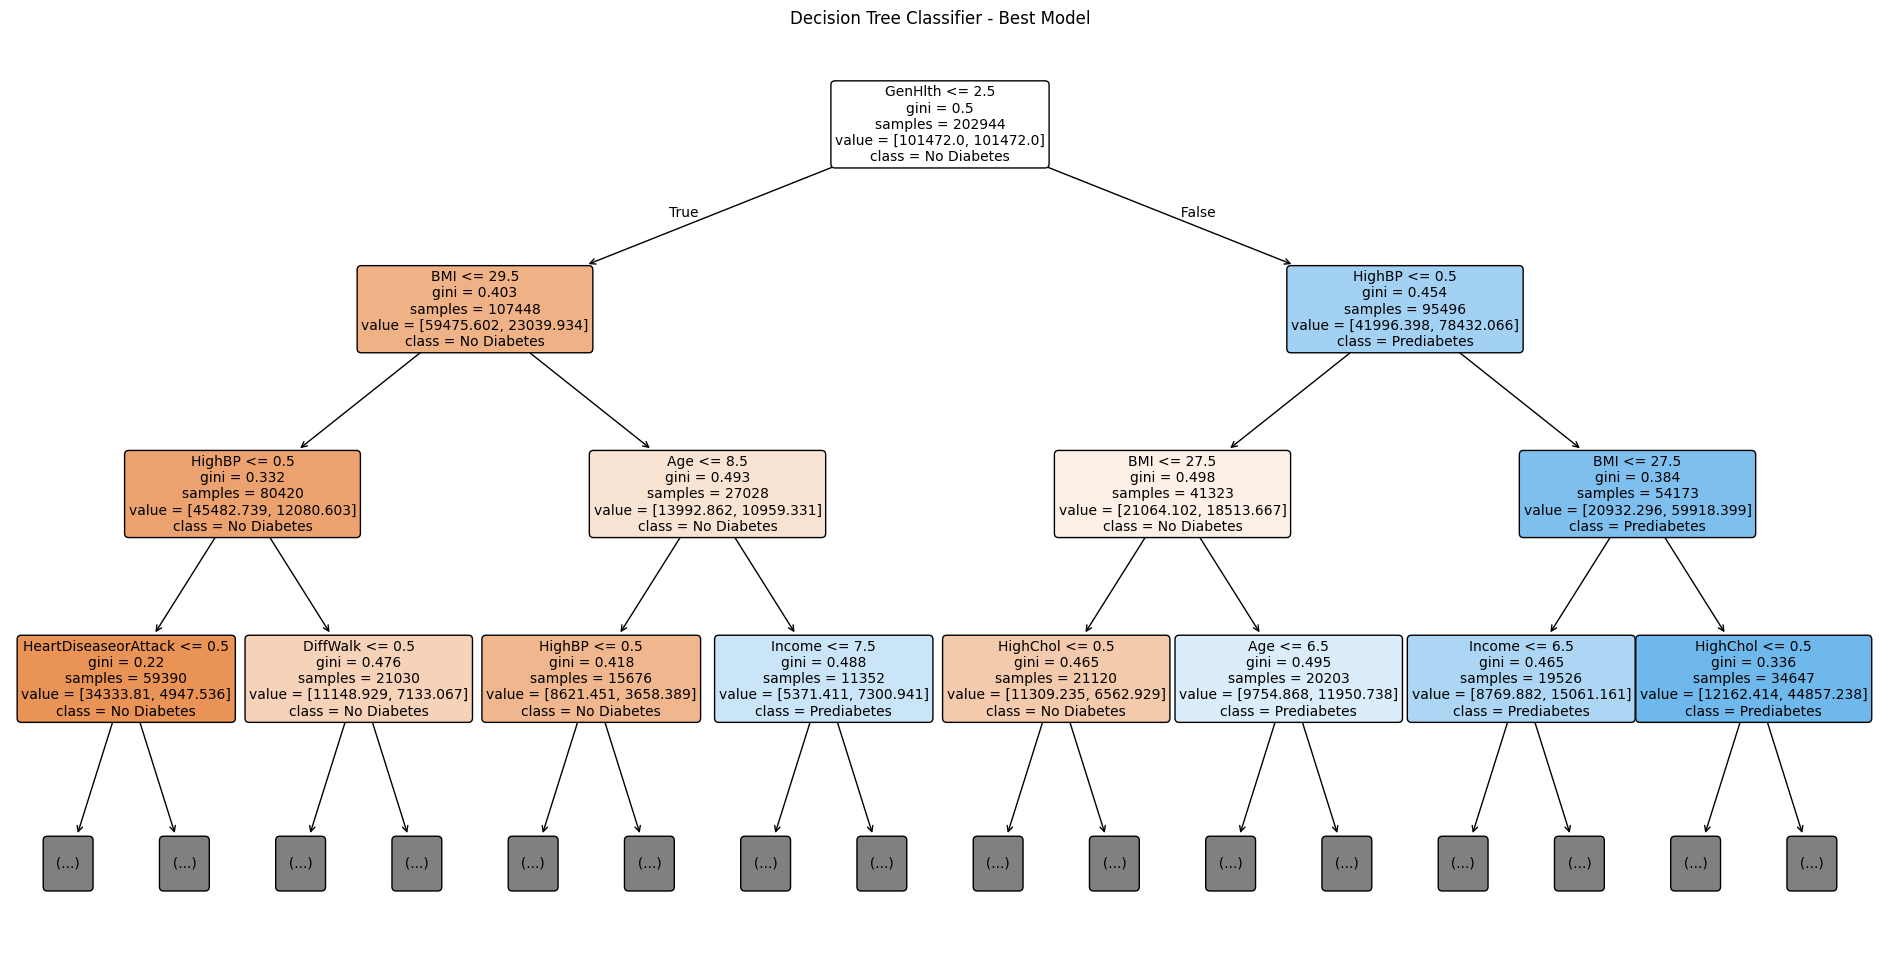

In [17]:
plt.figure(figsize=(24, 12))
plot_tree(
    best_model,
    max_depth=3,
    filled=True,
    feature_names=X_train.columns,
    class_names=["No Diabetes", "Prediabetes", "Diabetes"],
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Classifier - Best Model")

plt.show()

### A.2 Logistic Regression Code + Output

In [18]:
%%R
model_glm <- glm(Diabetes_binary ~ ., data = diabetes_train, family = "binomial")
print(summary(model_glm))


Call:
glm(formula = Diabetes_binary ~ ., family = "binomial", data = diabetes_train)

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -7.4663241  0.0965399 -77.339  < 2e-16 ***
HighBP                0.7035574  0.0154728  45.470  < 2e-16 ***
HighChol              0.5768167  0.0143957  40.069  < 2e-16 ***
CholCheck             1.2067387  0.0691757  17.445  < 2e-16 ***
BMI                   0.0620769  0.0009817  63.233  < 2e-16 ***
Smoker               -0.0096330  0.0140794  -0.684 0.493854    
Stroke                0.1128093  0.0274261   4.113 3.90e-05 ***
HeartDiseaseorAttack  0.2103541  0.0193664  10.862  < 2e-16 ***
PhysActivity         -0.0413393  0.0154976  -2.667 0.007643 ** 
Fruits               -0.0405170  0.0146248  -2.770 0.005598 ** 
Veggies              -0.0436544  0.0170391  -2.562 0.010407 *  
HvyAlcoholConsump    -0.6454978  0.0387525 -16.657  < 2e-16 ***
AnyHealthcare         0.0366985  0.0351045   1.045 0.295834    
NoD

In [19]:
%%R
pred_probs <- predict(model_glm, newdata = diabetes_test, type = "response")
pred_labels <- ifelse(pred_probs > 0.5, 1, 0)
accuracy <- mean(pred_labels == diabetes_test$Diabetes_binary)
cat("Baseline GLM Accuracy (Threshold = 0.5):", accuracy, "\n")
confusionMatrix(factor(pred_labels), factor(diabetes_test$Diabetes_binary), positive = "1")

Baseline GLM Accuracy (Threshold = 0.5): 0.8493772 
Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 41583  6430
         1  1212  1511
                                          
               Accuracy : 0.8494          
                 95% CI : (0.8462, 0.8525)
    No Information Rate : 0.8435          
    P-Value [Acc > NIR] : 0.0001238       
                                          
                  Kappa : 0.2211          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.19028         
            Specificity : 0.97168         
         Pos Pred Value : 0.55490         
         Neg Pred Value : 0.86608         
             Prevalence : 0.15652         
         Detection Rate : 0.02978         
   Detection Prevalence : 0.05367         
      Balanced Accuracy : 0.58098         
                                          
       'P

In [21]:
%%R
pred_probs <- predict(model_glm_reduced, newdata = diabetes_test, type = "response")
pred_labels <- ifelse(pred_probs > 0.3, 1, 0)
accuracy <- mean(pred_labels == diabetes_test$Diabetes_binary)
cat("Reduced GLM Accuracy (Threshold = 0.3):", accuracy, "\n")

confusionMatrix(
  factor(pred_labels),
  factor(diabetes_test$Diabetes_binary),
  positive = "1"
)

Reduced GLM Accuracy (Threshold = 0.3): 0.8213892 
Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 37827  4094
         1  4968  3847
                                         
               Accuracy : 0.8214         
                 95% CI : (0.818, 0.8247)
    No Information Rate : 0.8435         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.3526         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.48445        
            Specificity : 0.88391        
         Pos Pred Value : 0.43642        
         Neg Pred Value : 0.90234        
             Prevalence : 0.15652        
         Detection Rate : 0.07582        
   Detection Prevalence : 0.17374        
      Balanced Accuracy : 0.68418        
                                         
       'Positive' Class : 1  

### A.3 K Nearest Neighbor Code + Output

In [22]:
%%R
predictors <- df_train[, -which(names(df_train) == "Diabetes_binary")]
predictors_scaled <- scale(predictors)
pca_result <- prcomp(predictors_scaled, center = TRUE, scale. = TRUE)

pca_scores <- pca_result$x
pca_selected <- pca_scores[, 1:17]

data_knn <- data.frame(pca_selected, Diabetes_binary = factor(df_train$Diabetes_binary))
cv_control <- trainControl(method = "cv", number = 10)

knn_fit_compare <- train(Diabetes_binary ~ ., data = data_knn, method = "knn", trControl = cv_control, tuneGrid = expand.grid(k = 37))
print(knn_fit_compare)

k-Nearest Neighbors 

202944 samples
    17 predictor
     2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 182649, 182649, 182649, 182650, 182650, 182650, ... 
Resampling results:

  Accuracy  Kappa    
  0.846603  0.1701837

Tuning parameter 'k' was held constant at a value of 37


In [23]:
%%R
knn_pred = knn(train = diabetes_train, test = diabetes_test, cl = diabetes_train$Diabetes_binary, k = 5)
confusionMatrix(knn_pred, factor(diabetes_test$Diabetes_binary))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 42211  3600
         1   584  4341
                                          
               Accuracy : 0.9175          
                 95% CI : (0.9151, 0.9199)
    No Information Rate : 0.8435          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6305          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9864          
            Specificity : 0.5467          
         Pos Pred Value : 0.9214          
         Neg Pred Value : 0.8814          
             Prevalence : 0.8435          
         Detection Rate : 0.8320          
   Detection Prevalence : 0.9029          
      Balanced Accuracy : 0.7665          
                                          
       'Positive' Class : 0               
                  

### A.4 Neural Network Code + Output

In [24]:
def recall_class_1(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=[1], average='macro')

scorer = make_scorer(recall_class_1)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=42))
])

param_grid = {
    'mlp__activation': ['relu'],
    'mlp__hidden_layer_sizes': [(100,)],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001],
    'mlp__max_iter': [200]
}

nn_model = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=3, 
    scoring=scorer, 
    verbose=1, 
    n_jobs=-1
)

nn_model.fit(X_train, y_train)

print("Best Parameters:", nn_model.best_params_)
print("Best Cross-Validated Recall:", nn_model.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,), 'mlp__max_iter': 200, 'mlp__solver': 'adam'}
Best Cross-Validated Recall: 0.20392701784693681


In [25]:
y_proba = nn_model.predict_proba(X_test)[:, 1]

y_pred= (y_proba >= 0.3).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Threshold = 0.3):")
print(cm)

print(classification_report(y_test, y_pred))

Confusion Matrix (Threshold = 0.3):
[[37114  5681]
 [ 3608  4333]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     42795
           1       0.43      0.55      0.48      7941

    accuracy                           0.82     50736
   macro avg       0.67      0.71      0.69     50736
weighted avg       0.84      0.82      0.83     50736

